In [116]:
import pandas as pd
from pymongo import MongoClient
from apyori import apriori
import seaborn as sns
from wordcloud import WordCloud
from config import DB
import matplotlib.pyplot as plt
import numpy as np

In [117]:
##connection to mongo db on cloud
# client = MongoClient(DB.MONGO_URL)
# db = client["adtProject"]
# df1 = pd.DataFrame(db["restaurant-1-orders"].find({}))
# df2 = pd.DataFrame(db["restaurant-2-orders"].find({}))


In [118]:
##connection to mongo db on localhost
client = MongoClient("localhost",27017)
db = client["adtProject"]
df1 = pd.DataFrame(db["restaurant-1-orders"].find({}))
df2 = pd.DataFrame(db["restaurant-2-orders"].find({}))

In [119]:
##changing column name in one dataframe to match with the other
df1 = df1.rename(columns={'Order Number': 'Order ID'})

In [120]:
df1.shape

(74818, 7)

In [121]:
df2.shape

(119183, 7)

In [122]:
##merging two datasets
df = pd.concat([df1, df2])

In [123]:
#describing dataset
df.dtypes

_id               object
Order id          object
Order Date        object
Item Name         object
Quantity          object
Product Price     object
Total products    object
Order Number      object
dtype: object

In [124]:
#total number of unique itemset
df['Item Name'].nunique()

381

In [125]:
#computing total price
df["total_price"] = df["Product Price"].astype(float) * df["Quantity"].astype(int)
df 


,_id,Order id,Order Date,Item Name,Quantity,Product Price,Total products,Order Number,total_price
0,6383b7e6cc9dcb9b78734955,16118,03/08/2019 20:25,Plain Papadum,2,0.8,6,NaN,1.60
1,6383b7e6cc9dcb9b78734956,16118,03/08/2019 20:25,King Prawn Balti,1,12.95,6,NaN,12.95
2,6383b7e6cc9dcb9b78734957,16118,03/08/2019 20:25,Garlic Naan,1,2.95,6,NaN,2.95
3,6383b7e6cc9dcb9b78734958,16118,03/08/2019 20:25,Mushroom Rice,1,3.95,6,NaN,3.95
4,6383b7e6cc9dcb9b78734959,16118,03/08/2019 20:25,Paneer Tikka Masala,1,8.95,6,NaN,8.95
...,...,...,...,...,...,...,...,...,...
119178,6383b837cc9dcb9b78763f22,NaN,13/02/2017 12:59,House Red wine 75cl,1,17.95,18,8144,17.95
119179,6383b837cc9dcb9b78763f23,NaN,03/01/2017 19:13,House white wine 75cl,1,17.95,6,7463,17.95
119180,6383b837cc9dcb9b78763f24,NaN,24/11/2016 18:35,House Red wine 75cl,1,17.95,6,6719,17.95
119181,6383b837cc9dcb9b78763f25,NaN,21/08/2016 17:55,House white wine 75cl,1,17.95,9,5251,17.95


In [126]:
#computing total cost per transaction
order_price = df.groupby("Order id")[["total_price",
                                            "Quantity"]].sum().reset_index()
temp_data = df.drop_duplicates(subset=["Order id"],
                                 keep="first").reset_index()
order_price["Order Date"] = temp_data["Order Date"]
order_price


,Order id,total_price,Order Date
0,10000,48.65,03/08/2019 20:25
1,10001,27.85,03/08/2019 20:17
2,10002,29.75,03/08/2019 20:09
3,10003,26.80,03/08/2019 20:01
4,10004,13.90,03/08/2019 19:44
...,...,...,...
13392,9995,22.05,23/02/2017 18:20
13393,9996,22.45,23/10/2016 16:03
13394,9997,26.75,24/12/2018 13:22
13395,9998,28.25,31/08/2017 12:20


In [127]:
#computing average price per order
print("Average price per order", order_price["total_price"].mean())

Average price per order 33.329659625289246


In [128]:
#converting order date to datetime format
df['Order Date'] = pd.to_datetime(df['Order Date'], errors='coerce')

C:\Users\Acer\AppData\Local\Temp\ipykernel_10668\3909108231.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3["Order Date"] = df3["Order Date"].dt.year


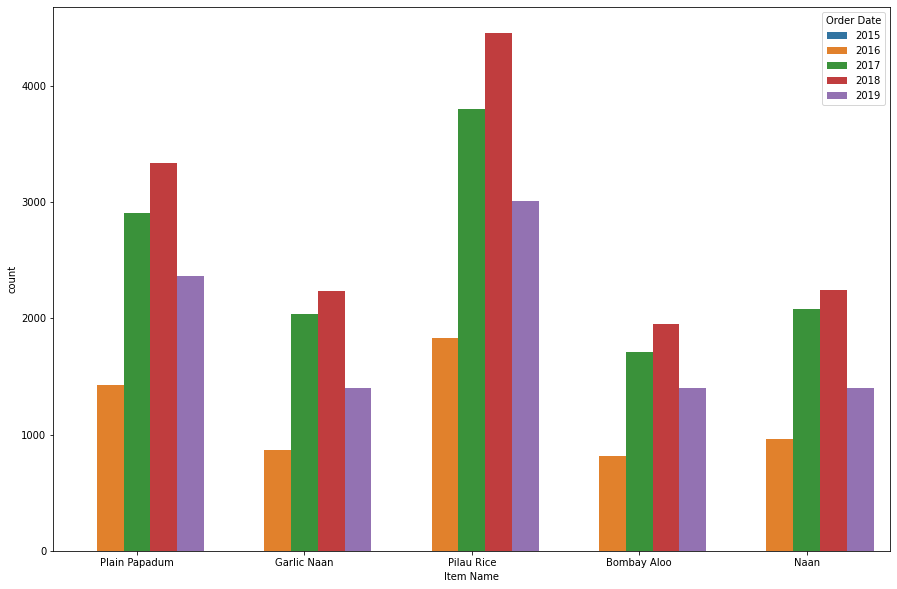

In [129]:
#sales of top sold items in a year wise distribution
condition = df["Item Name"].value_counts()[:5].index
df3 = df[df["Item Name"].apply(lambda x: x in condition)]
df3["Order Date"] = df3["Order Date"].dt.year
sns.countplot(data=df3, x="Item Name", hue="Order Date")
plt.show()

C:\Users\Acer\AppData\Local\Temp\ipykernel_10668\83945145.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3["Order Date"] = df3["Order Date"].dt.month


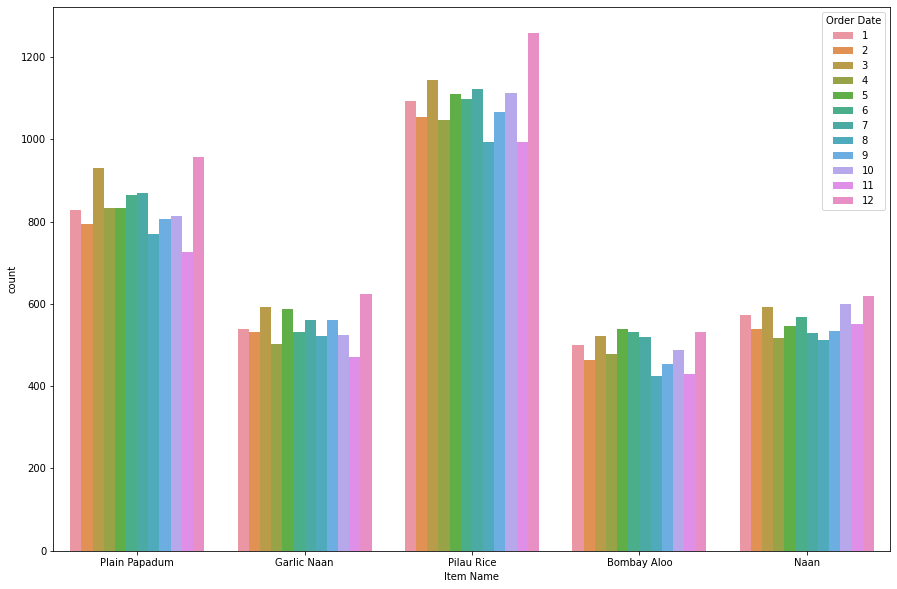

In [130]:
#sales of top sold items in a year wise distribution
condition = df["Item Name"].value_counts()[:5].index
df3 = df[df["Item Name"].apply(lambda x: x in condition)]
df3["Order Date"] = df3["Order Date"].dt.month
sns.countplot(data=df3, x="Item Name", hue="Order Date")
plt.show()

In [131]:
#computing number of orders as per weekdays
df['weekday'] = df['Order Date'].dt.weekday
df['weekday'] += 1

grouped_df_weekday = df.groupby(by='weekday')['Order Number'].count()
grouped_df_weekday

weekday
1    11484
2    11821
3    12316
4    13455
5    21976
6    30188
7    17943
Name: Order Number, dtype: int64

Text(0.5, 1.0, 'Order volume by weekday')

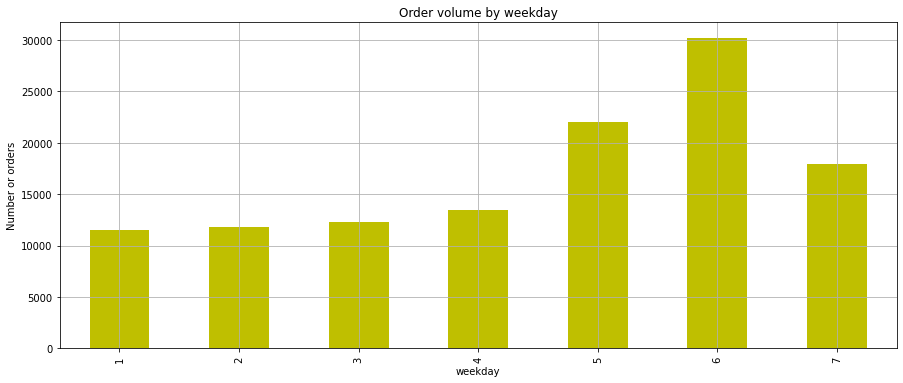

In [132]:
#barchart representing number of orders based on weekdays where 1 represents Monday and so on...
grouped_df_weekday.plot(kind = 'bar', color = 'y', figsize= (15,6))
plt.grid()
plt.ylabel('Number or orders')
plt.title('Order volume by weekday')

In [133]:
orders_grouped = pd.DataFrame(df.groupby(by='Order Number').total_price.sum()).sort_values('total_price')
# filter out some outliers
orders_grouped_filtered = orders_grouped[orders_grouped.total_price < 100]

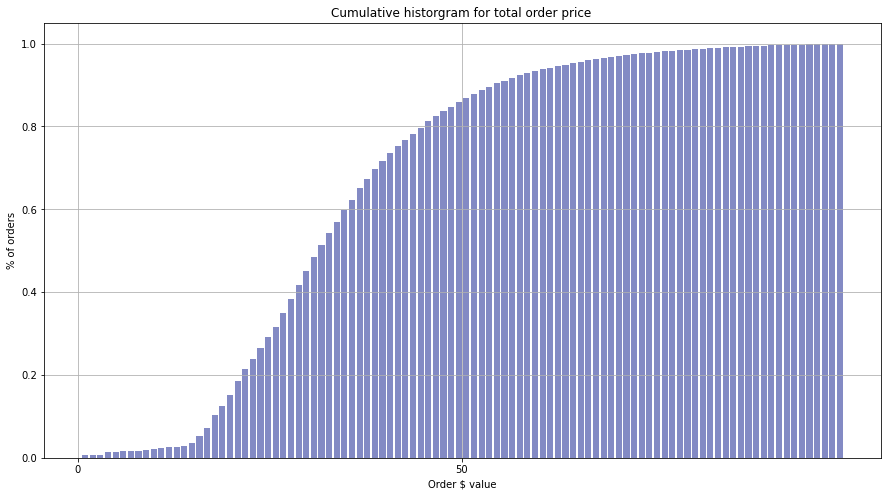

In [134]:
#% of orders in coparision to their prices
orders_grouped_filtered.hist(bins = 100, rwidth = 0.8, figsize= (15,8), cumulative = True, density = True, color = '#838ac4')
plt.xticks(np.arange(0,100, 50))
plt.title('Cumulative historgram for total order price ')
plt.ylabel('% of orders')
plt.xlabel('Order $ value')
plt.show()

In [135]:
#grouping data by transaction id
transformedDF = (df.groupby('Order id').head(len(df))
   .groupby('Order id')['Item Name'].agg(list)
).reset_index()
transformedDF

,Order id,Item Name
0,10000,"[Plain Rice, Royal Paneer, Aloo Gobi, Saag Alo..."
1,10001,"[Bombay Aloo, Dupiaza - Chicken, King Prawn Bi..."
2,10002,"[Garlic Naan, Paratha, Aloo Chaat, Sheek Kebab..."
3,10003,"[Bottle Diet Coke, Saag Paneer, Lamb Tikka Mas..."
4,10004,"[Saag Rice, Chicken Roshni]"
...,...,...
13392,9995,"[Mint Sauce, Plain Papadum, Plain Naan, Pilau ..."
13393,9996,"[Plain Naan, Pilau Rice, Madras - Chicken Tikk..."
13394,9997,"[Paratha, Garlic Naan, Prawn Puree, Tarka Dall..."
13395,9998,"[Onion Chutney, Meat Samosa, Tandoori Chicken ..."


In [136]:
df = pd.DataFrame([x for x in transformedDF['Item Name']])
# df.columns = [x for x in df.columns]
df

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,Plain Rice,Royal Paneer,Aloo Gobi,Saag Aloo,Chicken Tikka Balti,Prawn Balti,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,Bombay Aloo,Dupiaza - Chicken,King Prawn Biryani,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,Garlic Naan,Paratha,Aloo Chaat,Sheek Kebab (Main),Paneer Tikka Karahi,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,Bottle Diet Coke,Saag Paneer,Lamb Tikka Masala,Lamb Tikka (Main),None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,Saag Rice,Chicken Roshni,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13392,Mint Sauce,Plain Papadum,Plain Naan,Pilau Rice,Saag Aloo,Madras - Chicken,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
13393,Plain Naan,Pilau Rice,Madras - Chicken Tikka,Chicken Tikka (Main),None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
13394,Paratha,Garlic Naan,Prawn Puree,Tarka Dall,Saag - Prawn,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
13395,Onion Chutney,Meat Samosa,Tandoori Chicken (1/4),Saag Dall,Lamb Tikka Chilli Masala,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


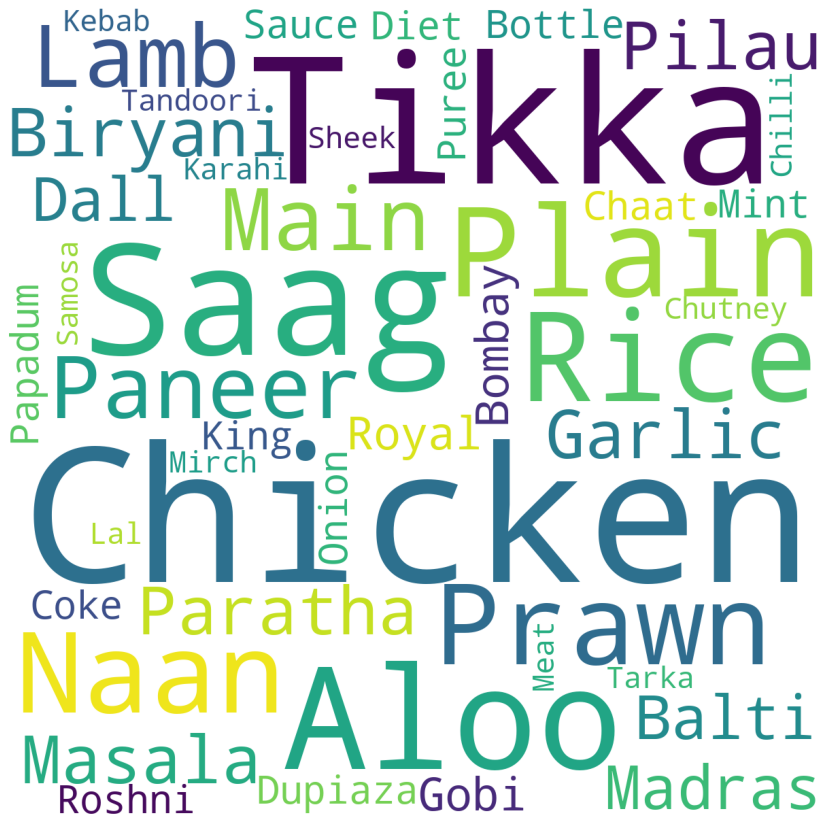

In [137]:
inp = str(df).replace('None', '')
inp = inp.replace("columns", "")
inp = inp.replace("rows", "")
inp = inp.replace("x", "")
plt.rcParams['figure.figsize'] = (15, 15)
wordcloud = WordCloud(background_color = 'white', width = 1200,  height = 1200, max_words = 100).generate(inp)
plt.imshow(wordcloud)
plt.axis('off')
# plt.title('Most Popular Items',fontsize = 20)
plt.show()

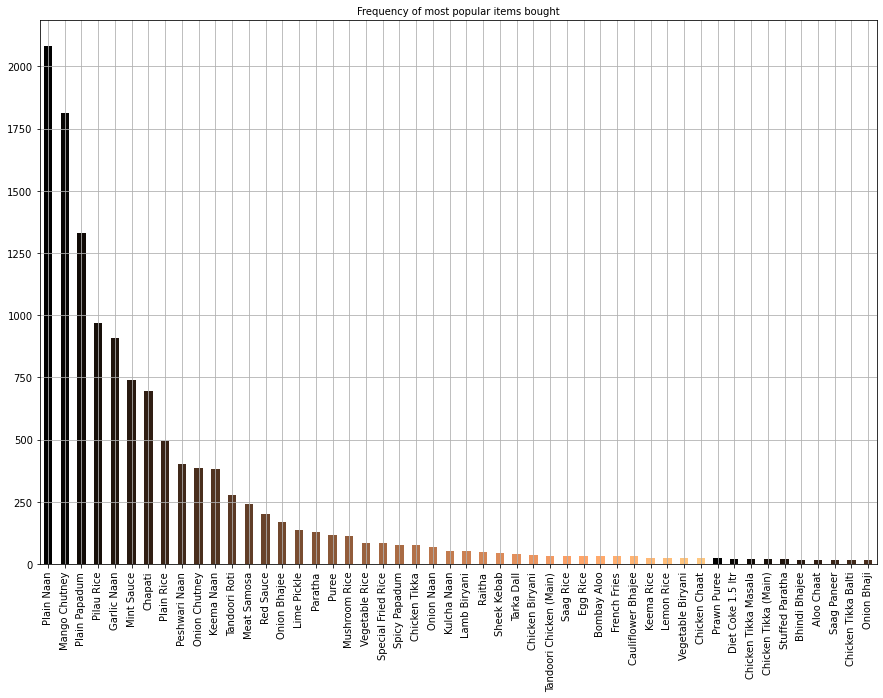

In [138]:
plt.rcParams['figure.figsize'] = (15, 10)
color = plt.cm.copper(np.linspace(0, 1, 40))
df[0].value_counts().head(50).plot.bar(color = color)
plt.title('Frequency of most popular items bought', fontsize = 10)
plt.xticks(rotation = 90 )
plt.grid()
plt.show()

In [152]:
dim = df.shape
rows = dim[0]
cols = dim[1]
transactions = []
for i in range(0, rows):
    transactions.append([ str(df.values[i,j]) for j in range(0, cols)])

In [154]:
#computing association rules using apriori algorithm
rule_list = apriori(transactions, min_support = 0.003, min_confidence = 0.1, min_lift = 3, min_length = 2)
results = list(rule_list)


In [155]:
bought_item = [tuple(result[2][0][0])[0] for result in results]
will_buy_item = [tuple(result[2][0][1])[0] for result in results]
support_values = [result[1] for result in results]
confidences = [result[2][0][2] for result in results]
lift_values = [result[2][0][3] for result in results]

In [156]:
op = pd.DataFrame(list(zip(bought_item, will_buy_item, support_values, confidences, lift_values)), columns = ['Bought Item', 'Expected To Be Bought', 'Support', 'Confidence', 'Lift'])
op

,Bought Item,Expected To Be Bought,Support,Confidence,Lift
0,Aloo Chaat,Vegetable Roll,0.003508,0.165493,7.752130
1,Aloo Gobi,Tandoori Roti,0.005150,0.112195,3.310745
2,Vegetable Biryani,Aloo Gobi,0.003658,0.153125,3.335635
3,Bhuna,Saag Bhajee,0.003732,0.107296,6.195889
4,Bhuna - Chicken Tikka,Mushroom Rice,0.003135,0.328125,3.027473
...,...,...,...,...,...
1943,Mango Chutney,Plain Naan,0.003284,0.107579,11.622920
1944,Mango Chutney,Onion Chutney,0.003732,0.148368,19.487112
1945,Mango Chutney,Onion Chutney,0.003284,0.130564,15.078993
1946,Mint Sauce,Onion Chutney,0.003807,0.136364,14.272372


In [ ]:
#deelting previous rules to update with newly generated rules to mongodb
db['rules'].delete_many({})
for i in range(len(bought_item)):
    db['rules'].insert_one({
        "_id": i,
        "Bought Item":bought_item[i],
        "Expected To Be Bought":will_buy_item[i],
        "Support":support_values[i],
        "Confidence":confidences[i],
        "Lift":lift_values[i],
     })